In [1]:
from pathlib import Path

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from scipy.stats import ttest_ind

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

### Load daily tasmax data

In [2]:
droot = Path("../data/processed/HadGEM3-GC31-LL")

expts = ["historical", "ssp585"]

expdict = {"historical": "hist-antwater-92-11", "ssp585": "ssp585-ismip6-water"}

In [6]:
ddict = {}
for exp in expts:
    print(exp)
    if exp == "historical":
        histdir = droot.joinpath("historical", "day", "tasmax")
        sspdir = droot.joinpath("ssp245", "day", "tasmax")

        hfiles = sorted(list(histdir.glob("*.nc")))
        sfiles = sorted(list(sspdir.glob("*.nc")))

        dsh = xr.open_mfdataset(hfiles, combine="nested", concat_dim="ensmem")
        dss = xr.open_mfdataset(sfiles, combine="nested", concat_dim="ensmem")

        dsc = xr.concat((dsh, dss), dim="time")
    else:
        cdir = droot.joinpath("ssp585", "day", "tasmax")
        cfiles = sorted(list(cdir.glob("*.nc")))

        dsc = xr.open_mfdataset(cfiles, combine="nested", concat_dim="ensmem")

    ddir = droot.joinpath(expdict[exp], "day", "tasmax")
    dfiles = sorted(list(ddir.glob("*.nc")))

    ensmem = [f.name.split("_")[4] for f in dfiles]

    dse = xr.open_mfdataset(dfiles, combine="nested", concat_dim="ensmem")

    dsc = dsc.assign_coords({"ensmem": ("ensmem", ensmem)})
    dse = dse.assign_coords({"ensmem": ("ensmem", ensmem)})

    dac = dsc["tasmax"].isel(time=slice(-240 * 30, None))
    dae = dse["tasmax"].isel(time=slice(-240 * 30, None))
    dap = dse["tasmax"].isel(time=slice(None, 240 * 30))

    dae = dae.rename({"latitude": "lat", "longitude": "lon"})
    dap = dap.rename({"latitude": "lat", "longitude": "lon"})

    ddict[exp] = {"ctrl": dac, "expt": dae, "pres": dap}

historical
ssp585


In [10]:
sdir = droot.joinpath("fx", "sftlf")
ncs = list(sdir.glob("*.nc"))[0]

dss = xr.open_dataset(ncs)

mask = dss["sftlf"]

### Compute number of hot days for NZ

In [11]:
def weightedmn(da):
    return da.weighted(np.cos(np.deg2rad(da.lat))).mean(("lat", "lon"))

In [12]:
nzdict = {}

for exp in expts:
    dac_nz = ddict[exp]["ctrl"].where(
        np.logical_and(ddict[exp]["ctrl"].lon > 155, ddict[exp]["ctrl"].lon < 190),
        drop=True,
    )
    dac_nz = dac_nz.where(np.logical_and(dac_nz.lat > -60, dac_nz.lat < -20), drop=True)

    dae_nz = ddict[exp]["expt"].where(
        np.logical_and(ddict[exp]["expt"].lon > 155, ddict[exp]["expt"].lon < 190),
        drop=True,
    )
    dae_nz = dae_nz.where(np.logical_and(dae_nz.lat > -60, dae_nz.lat < -20), drop=True)

    dap_nz = ddict[exp]["pres"].where(
        np.logical_and(ddict[exp]["pres"].lon > 155, ddict[exp]["pres"].lon < 190),
        drop=True,
    )
    dap_nz = dap_nz.where(np.logical_and(dap_nz.lat > -60, dap_nz.lat < -20), drop=True)

    dac_nz = dac_nz.where(mask > 0, drop=True)
    dae_nz = dae_nz.where(mask > 0, drop=True)
    dap_nz = dap_nz.where(mask > 0, drop=True)

    nzdict[exp] = {"ctrl": dac_nz, "expt": dae_nz, "pres": dap_nz}

In [15]:
def get_hotdays(da):
    test = da - 273.15
    test2 = test.where(test > 25, 0)
    test3 = test2.where(test2 == 0, 1)

    return test3.groupby("time.year").sum("time")


hot_e = get_hotdays(nzdict["ssp585"]["expt"]).compute()
hot_c = get_hotdays(nzdict["ssp585"]["ctrl"]).compute()
hot_p = get_hotdays(nzdict["historical"]["ctrl"]).compute()

In [21]:
panom = (hot_c.where(mask>0).mean("ensmem") - hot_e.where(mask>0).mean("ensmem")).mean("year")
eanom = (hot_e.where(mask>0).mean("ensmem") - hot_c.where(mask>0).mean("ensmem")).mean("year")

### Make plot

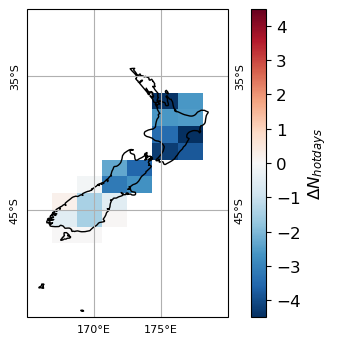

In [30]:
fig = plt.figure(1)
axs = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
axs.coastlines()
axs.set_extent([165, 180, -53, -30], crs=ccrs.PlateCarree())
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([170, 175])
gl.ylocator = mticker.FixedLocator([-45, -35])
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
im = eanom.plot.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree(), cbar_kwargs={"label": "$\Delta N_{hot days}$"})

levels = [0, 0.05, 0.1, 1]
cs = pvale.plot.contourf(
    "lon",
    "lat",
    ax=axs,
    transform=ccrs.PlateCarree(),
    levels=levels,
    hatches=["....", "", ""],
    colors="none",
    add_colorbar=False,
)

cs.set_edgecolor("tab:gray")
cs.set_linewidth(0.0)

fig.savefig("../figures/delta_hotdays.png", bbox_inches="tight", dpi=300)

### Assess statistical significance

In [28]:
statsig = float(3*(weightedmn(hot_e.where(mask > 0)).mean("year").std("ensmem")/np.sqrt(4)))
anomaly = eanom.weighted(np.cos(np.deg2rad(eanom.lat))).mean(("lat", "lon")).data
print(f"Statistical significance threshold is {statsig:5.4f} and anomaly is {anomaly:5.4f}")

Statistical significance threshold is 0.8251 and anomaly is -2.1456
